In [1]:
! pip install torchinfo

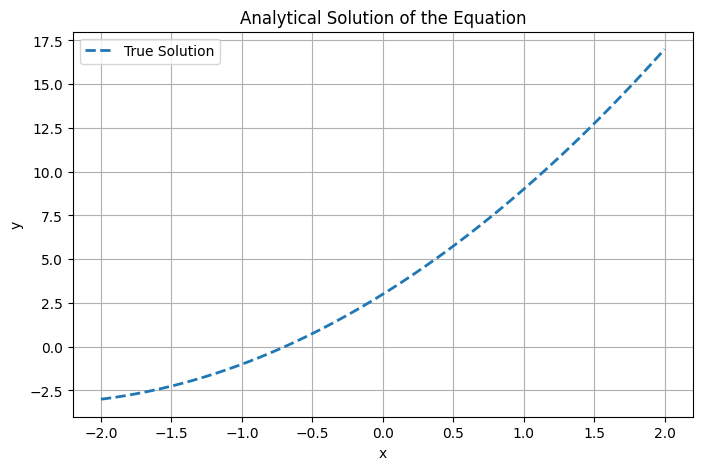

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchinfo import summary

# precise sol
def true_solution(x):
    return x**2+5*x+3

x_test=torch.linspace(-2,2,100).view(-1,1)
y_true=true_solution(x_test)

plt.figure(figsize=(8,5))

# plot precise sol
plt.plot(

    x_test,
    y_true,
    linestyle="dashed",
    linewidth=2,
    label="True Solution"
)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Analytical Solution of the Equation")
plt.grid()
plt.show()


In [13]:
# design structure of PINN
class PINN(nn.Module):
    def __init__(self):
        super(PINN,self).__init__()
        self.net=nn.Sequential(
            nn.Linear(1,20),nn.Tanh(),
            nn.Linear(20,20),nn.Tanh(),
            nn.Linear(20,1)
        )


    def forward(self,x):
        return self.net(x)


model=PINN()
optimizer=optim.Adam(model.parameters(),lr=1e-3)
summary(model)




Layer (type:depth-idx)                   Param #
PINN                                     --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       40
│    └─Tanh: 2-2                         --
│    └─Linear: 2-3                       420
│    └─Tanh: 2-4                         --
│    └─Linear: 2-5                       21
Total params: 481
Trainable params: 481
Non-trainable params: 0

In [14]:
def pinn_loss(model,x):
    x.requires_grad=True
    y=model(x)

    # auto-derivative
    dy_dx=torch.autograd.grad(y,x,torch.ones_like(y),create_graph=True)[0]

    # Differential Equation Losses (L_D):dy/dx-(2x+5)
    ode_loss=torch.mean((dy_dx-(2*x+5))**2)

    # Boudary Losses (L_B):y(0)=3
    x0=torch.tensor([[0.0]])
    y0_pred=model(x0)
    initial_loss=(y0_pred-3)**2

    # total Losses
    total_loss=ode_loss+initial_loss
    return total_loss,ode_loss,initial_loss
    

In [15]:
# train

epochs=5000
loss_history=[]
ode_loss_history=[]
initial_loss_history=[]

x_train=torch.linspace(-2,2,100).view(-1,1) # train spot

for epoch in range(epochs):
    optimizer.zero_grad()
    total_loss,ode_loss,initial_loss=pinn_loss(model,x_train)
    total_loss.backward()
    optimizer.step()

    loss_history.append(total_loss.item())
    ode_loss_history.append(ode_loss.item())
    initial_loss_history.append(initial_loss.item())

    if epoch%1000==0:
        print(f"Epoch {epoch},Loss:{total_loss.item():.6f}")

Epoch 0,Loss:42.500557
Epoch 1000,Loss:0.625061
Epoch 2000,Loss:0.005133
Epoch 3000,Loss:0.000857
Epoch 4000,Loss:0.000397


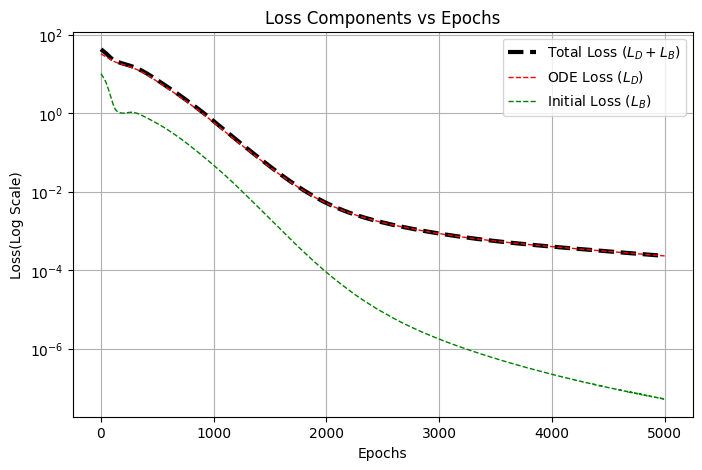

In [17]:
# plot loss during train
plt.figure(figsize=(8,5))
epochs_list=np.arange(1,epochs+1)

plt.semilogy(epochs_list,loss_history,'k--',linewidth=3,label=r'Total Loss $(L_D+L_B)$')
plt.semilogy(epochs_list,ode_loss_history,'r--',linewidth=1,label=r'ODE Loss $(L_D)$')
plt.semilogy(epochs_list,initial_loss_history,'g--',linewidth=1,label=r'Initial Loss $(L_B)$')

plt.xlabel("Epochs")
plt.ylabel("Loss(Log Scale)")
plt.legend()
plt.title("Loss Components vs Epochs")
plt.grid()
plt.show()

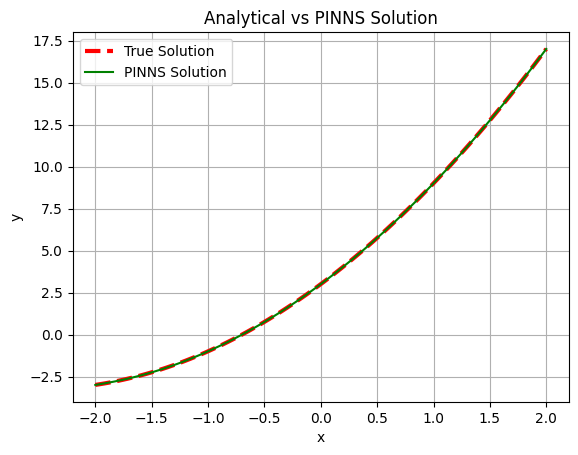

In [20]:
# Compare
X_test=torch.linspace(-2,2,100).view(-1,1)
y_pred=model(X_test).detach().numpy()

plt.plot(X_test,true_solution(X_test),linestyle="dashed",linewidth=3,label="True Solution",color="red")
plt.plot(X_test,y_pred,label="PINNS Solution",color="green")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title(r'Analytical vs PINNS Solution')
plt.savefig("solution.png",dpi=300,bbox_inches='tight')
plt.grid()
plt.show()